**DATA IMPORT AND AUGMENTATION**

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [51]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

In [52]:
#Create new path to store augmented images
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [53]:
def load_data(path):
  train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
  train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

  test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
  test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

  return (train_x, train_y), (test_x,test_y)

In [54]:
def augment_data(images, masks, save_path, augment=True):
  size=(512,512)

  #Now we loop over image and mask
  for idx, (x,y) in tqdm(enumerate(zip(images,masks)), total=len(images)):
    #extracting name of the image
    name = (x.split('/')[-1]).split(".")[0]

    #Reading the image and mask
    #for image we use cv2 and for the mask we use imageio

    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = imageio.mimread(y)[0]
    if augment == True:
      aug = HorizontalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x1 = augmented["image"]
      y1 = augmented["mask"]

      aug = VerticalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x2 = augmented["image"]
      y2 = augmented["mask"]

      aug = Rotate(limit=45, p=1.0)
      augmented = aug(image=x, mask=y)
      x3 = augmented["image"]
      y3 = augmented["mask"]

      X = [x, x1, x2, x3]
      Y = [y, y1, y2, y3]

    else:
      X = [x]
      Y = [y]

    index = 0
    for i, m in zip(X,Y):
      i = cv2.resize(i, size)
      m = cv2.resize(m, size)

      tmp_image_name = f"{name}_{index}.png"
      tmp_mask_name = f"{name}_{index}.png"

      image_path = os.path.join(save_path, "image", tmp_image_name)
      mask_path = os.path.join(save_path, "mask", tmp_mask_name)  

      cv2.imwrite(image_path, i)
      cv2.imwrite(mask_path, m)  

      index+=1


In [55]:
if __name__ == "main":
  np.random.seed(42)

In [56]:
##Load the data
data_path = "/content/drive/MyDrive/Retina Vessel Segmentation/DRIVE/"
(train_x, train_y), (test_x,test_y) = load_data(data_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 20 - 20
Test: 20 - 20


In [57]:
#Now we create directories to save our augmented data
create_dir("new_data/train/image/")
create_dir("new_data/train/mask/")
create_dir("new_data/test/image/")
create_dir("new_data/test/mask/")

In [58]:
#Data augmentation
augment_data(train_x,train_y,"new_data/train/",augment=False)

100%|██████████| 20/20 [00:00<00:00, 32.31it/s]


In [59]:
augment_data(test_x,test_y,"new_data/test/",augment=False)

100%|██████████| 20/20 [00:00<00:00, 32.49it/s]


**CREATING U-NET ARCHITECTURE**

In [60]:
import torch
import torch.nn as nn

In [61]:
class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv1 = nn.Conv2d(in_c,out_c,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)

    self.conv2 = nn.Conv2d(out_c,out_c,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    return x


class encoder_block(nn.Module):
  def __init__(self, in_c,out_c):
    super().__init__()

    self.conv = conv_block(in_c, out_c)
    self.pool = nn.MaxPool2d((2,2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)

    return x,p

class decoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
    #Number of input channels will be outputchannles*2
    self.conv = conv_block(out_c+out_c, out_c)

  def forward(self, inputs, skip):
    x = self.up(inputs)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x
   


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        ##Encoder 
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        ##Bottleneck
        self.b = conv_block(512, 1024)  

        ##Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)


        ##Classifier 
        #To generate the final segmentation
        self.outputs = nn.Conv2d(64,1, kernel_size=1, padding=0)

    
    def forward(self, inputs):
        ##Encoder 
        #The output from the encoder layer acts as a skip connection for the decoder layer
        #s1 stands for skip connections
        #p1 stands for pooling output

        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        #Bottleneck
        b = self.b(p4)
        #print(s1.shape, s2.shape, s3.shape, s4.shape)
        #print(b.shape)

        ##Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        #Classifier
        outputs = self.outputs(d4)
        return outputs



if __name__ == "__main__":
  x = torch.randn((2,3,512,512))
  f = build_unet()
  y=f(x)
  print(y.shape)

torch.Size([2, 1, 512, 512])


**LOSS**

In [62]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [63]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

**UTILS**

In [64]:
import os
import time
import random
import numpy as np
import cv2
import torch

##Seeding the randomness
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

##Create a directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

##Calculate the time taken
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**TRAINING**

In [65]:
import os
import time
from glob import glob

from torch.utils.data import DataLoader

In [66]:
if __name__ == "__main__":
  #Seeding
  seeding(42)

  #Saving the checkpoints and other files
  create_dir("files")

  #load the dataset
  train_x = sorted(glob("/content/new_data/train/image/*"))
  train_y = sorted(glob("/content/new_data/train/mask/*"))

  valid_x = sorted(glob("/content/new_data/test/image/*"))
  valid_y = sorted(glob("/content/new_data/test/mask/*"))

  data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid:{len(test_x)}"
  print(data_str)

Dataset Size:
Train: 20 - Valid:20


In [67]:
##Hyperparameters
H = 512
W = 512
size = (H,W)
batch_size = 4
num_epochs = 200
lr = 0.0001
checkpoint_path = "files/checkpoint.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


**DATASET AND LOADER**

In [68]:
import os 
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

In [69]:
class DriveDataset(Dataset):
  def __init__(self, images_path, masks_path):
    self.images_path = images_path
    self.masks_path = masks_path
    self.n_samples = len(images_path)

  def __getitem__(self, index):
    #Reading the image
    #Read the image in RGB format
    image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
    #Normalize the image by dividing with 255
    image = image/255.0
    #Transpose the image since it had channel last approach and for pytorch we need channel first
    image = np.transpose(image, (2,0,1))
    #Then we convert it into float32
    image = image.astype(np.float32)
    #Then we convert it to a torch tensor
    image = torch.from_numpy(image)

    #Reading the mask
    #We do not need transpose for mask
    mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = np.expand_dims(mask, axis=0)##(1,512,512)
    mask = mask.astype(np.float32)
    mask = torch.from_numpy(mask)

    return image, mask

  def __len__(self):
    return self.n_samples


In [70]:
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers=2
)

In [71]:
##Initialising the model
model = build_unet()
model = model.to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [72]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred, type="All"):
    ##Ground truth
    y_true = y_true.cpu().detach().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    ##Prediction 
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    if type == "Jaccard":
      return score_jaccard
    elif type == "F1":
      return score_f1
    elif type == "Recall":
      return score_recall
    elif type == "Precision":
      return score_precision
    elif type == "Accuracy":
      return score_acc
    else:
      return [score_jaccard,score_f1,score_recall,score_precision,score_acc]

In [73]:
##Specify the training function

def train(model, loader, optimizer, loss_fn, device):
  epoch_loss = 0.0
  model.train()
  for x,y in tqdm(loader):
    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)

    #Optimizer put to zero grad
    optimizer.zero_grad()
    #Making a prediction
    y_pred = model(x)
    #Calculating loss
    loss = loss_fn(y_pred, y)
    #Backward step
    loss.backward()
    #Optimizer step
    optimizer.step()
    #Getting the loss for that epoch
    epoch_loss+=loss.item()
    

  #Calculating mean loss
  epoch_loss = epoch_loss/len(loader)

  return epoch_loss

In [74]:
##Specify the evaluate function
def evaluate(model, loader, loss_fn, device):
  epoch_loss = 0.0
  model.eval()
  with torch.no_grad():
    for x,y in tqdm(loader):
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)

      y_pred = model(x)
      loss = loss_fn(y_pred,y)

      epoch_loss+=loss.item()

  #Calculating mean loss
  epoch_loss = epoch_loss/len(loader)
  return epoch_loss

In [75]:
##Training the model
best_valid_loss = float("inf")
loss_store = []
val_loss_store = []
epoch_count = []

for epoch in range(num_epochs):
  start_time = time.time()
  train_loss = train(model, train_loader, optimizer, loss_fn, device)
  loss_store.append(train_loss)
  valid_loss = evaluate(model, valid_loader, loss_fn, device)
  val_loss_store.append(valid_loss)

  #Saving the model
  if valid_loss < best_valid_loss:
    data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:4f}"
    print(data_str)

    best_valid_loss = valid_loss
    torch.save(model.state_dict(), checkpoint_path)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  #Storing values
  epoch_count.append(epoch)


  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
  data_str += f'\tTrain Loss: {train_loss:.3f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
  print(data_str)

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Valid loss improved from inf to 1.491523
Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.372
	 Val. Loss: 1.492



100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Valid loss improved from 1.4915 to 1.482258
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.282
	 Val. Loss: 1.482



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 1.4823 to 1.469061
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 1.204
	 Val. Loss: 1.469



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 1.4691 to 1.440719
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 1.145
	 Val. Loss: 1.441



100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Valid loss improved from 1.4407 to 1.414576
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 1.094
	 Val. Loss: 1.415



100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Valid loss improved from 1.4146 to 1.393406
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 1.061
	 Val. Loss: 1.393



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 1.3934 to 1.373763
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 1.035
	 Val. Loss: 1.374



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 1.3738 to 1.344855
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 1.015
	 Val. Loss: 1.345



100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Valid loss improved from 1.3449 to 1.263275
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.002
	 Val. Loss: 1.263



100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Valid loss improved from 1.2633 to 1.171690
Epoch: 10 | Epoch Time: 0m 11s
	Train Loss: 0.992
	 Val. Loss: 1.172



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 1.1717 to 1.115374
Epoch: 11 | Epoch Time: 0m 11s
	Train Loss: 0.980
	 Val. Loss: 1.115



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 1.1154 to 1.050056
Epoch: 12 | Epoch Time: 0m 10s
	Train Loss: 0.968
	 Val. Loss: 1.050



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 1.0501 to 1.000329
Epoch: 13 | Epoch Time: 0m 10s
	Train Loss: 0.958
	 Val. Loss: 1.000



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 1.0003 to 0.962698
Epoch: 14 | Epoch Time: 0m 10s
	Train Loss: 0.949
	 Val. Loss: 0.963



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.9627 to 0.947751
Epoch: 15 | Epoch Time: 0m 10s
	Train Loss: 0.939
	 Val. Loss: 0.948



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.9478 to 0.937365
Epoch: 16 | Epoch Time: 0m 10s
	Train Loss: 0.931
	 Val. Loss: 0.937



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.9374 to 0.928408
Epoch: 17 | Epoch Time: 0m 10s
	Train Loss: 0.921
	 Val. Loss: 0.928



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.9284 to 0.911182
Epoch: 18 | Epoch Time: 0m 11s
	Train Loss: 0.917
	 Val. Loss: 0.911



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.9112 to 0.904620
Epoch: 19 | Epoch Time: 0m 10s
	Train Loss: 0.909
	 Val. Loss: 0.905



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.9046 to 0.902470
Epoch: 20 | Epoch Time: 0m 10s
	Train Loss: 0.900
	 Val. Loss: 0.902



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.9025 to 0.901396
Epoch: 21 | Epoch Time: 0m 10s
	Train Loss: 0.891
	 Val. Loss: 0.901



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.9014 to 0.894348
Epoch: 22 | Epoch Time: 0m 10s
	Train Loss: 0.887
	 Val. Loss: 0.894



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8943 to 0.893287
Epoch: 23 | Epoch Time: 0m 10s
	Train Loss: 0.881
	 Val. Loss: 0.893



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 0.8933 to 0.881828
Epoch: 24 | Epoch Time: 0m 10s
	Train Loss: 0.872
	 Val. Loss: 0.882



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8818 to 0.877330
Epoch: 25 | Epoch Time: 0m 10s
	Train Loss: 0.867
	 Val. Loss: 0.877



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8773 to 0.869765
Epoch: 26 | Epoch Time: 0m 10s
	Train Loss: 0.859
	 Val. Loss: 0.870



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8698 to 0.869228
Epoch: 27 | Epoch Time: 0m 10s
	Train Loss: 0.854
	 Val. Loss: 0.869



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Valid loss improved from 0.8692 to 0.860227
Epoch: 28 | Epoch Time: 0m 11s
	Train Loss: 0.850
	 Val. Loss: 0.860



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.8602 to 0.848246
Epoch: 29 | Epoch Time: 0m 10s
	Train Loss: 0.842
	 Val. Loss: 0.848



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.8482 to 0.846295
Epoch: 30 | Epoch Time: 0m 10s
	Train Loss: 0.833
	 Val. Loss: 0.846



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8463 to 0.846117
Epoch: 31 | Epoch Time: 0m 10s
	Train Loss: 0.825
	 Val. Loss: 0.846



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 32 | Epoch Time: 0m 10s
	Train Loss: 0.818
	 Val. Loss: 0.847



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8461 to 0.838927
Epoch: 33 | Epoch Time: 0m 10s
	Train Loss: 0.809
	 Val. Loss: 0.839



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8389 to 0.837139
Epoch: 34 | Epoch Time: 0m 10s
	Train Loss: 0.805
	 Val. Loss: 0.837



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.8371 to 0.832037
Epoch: 35 | Epoch Time: 0m 10s
	Train Loss: 0.796
	 Val. Loss: 0.832



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8320 to 0.821895
Epoch: 36 | Epoch Time: 0m 10s
	Train Loss: 0.790
	 Val. Loss: 0.822



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 37 | Epoch Time: 0m 10s
	Train Loss: 0.786
	 Val. Loss: 0.830



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.8219 to 0.813548
Epoch: 38 | Epoch Time: 0m 10s
	Train Loss: 0.779
	 Val. Loss: 0.814



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.8135 to 0.808575
Epoch: 39 | Epoch Time: 0m 10s
	Train Loss: 0.771
	 Val. Loss: 0.809



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.8086 to 0.802815
Epoch: 40 | Epoch Time: 0m 10s
	Train Loss: 0.763
	 Val. Loss: 0.803



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 41 | Epoch Time: 0m 10s
	Train Loss: 0.757
	 Val. Loss: 0.804



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.8028 to 0.798701
Epoch: 42 | Epoch Time: 0m 10s
	Train Loss: 0.751
	 Val. Loss: 0.799



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 43 | Epoch Time: 0m 10s
	Train Loss: 0.742
	 Val. Loss: 0.799



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.7987 to 0.791876
Epoch: 44 | Epoch Time: 0m 10s
	Train Loss: 0.737
	 Val. Loss: 0.792



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7919 to 0.790247
Epoch: 45 | Epoch Time: 0m 10s
	Train Loss: 0.731
	 Val. Loss: 0.790



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.7902 to 0.779449
Epoch: 46 | Epoch Time: 0m 10s
	Train Loss: 0.724
	 Val. Loss: 0.779



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7794 to 0.778022
Epoch: 47 | Epoch Time: 0m 10s
	Train Loss: 0.718
	 Val. Loss: 0.778



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 0.7780 to 0.774584
Epoch: 48 | Epoch Time: 0m 10s
	Train Loss: 0.712
	 Val. Loss: 0.775



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 49 | Epoch Time: 0m 10s
	Train Loss: 0.710
	 Val. Loss: 0.776



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.7746 to 0.771057
Epoch: 50 | Epoch Time: 0m 11s
	Train Loss: 0.703
	 Val. Loss: 0.771



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7711 to 0.763641
Epoch: 51 | Epoch Time: 0m 11s
	Train Loss: 0.699
	 Val. Loss: 0.764



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.7636 to 0.763349
Epoch: 52 | Epoch Time: 0m 11s
	Train Loss: 0.693
	 Val. Loss: 0.763



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7633 to 0.763138
Epoch: 53 | Epoch Time: 0m 10s
	Train Loss: 0.687
	 Val. Loss: 0.763



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 0.7631 to 0.752709
Epoch: 54 | Epoch Time: 0m 10s
	Train Loss: 0.680
	 Val. Loss: 0.753



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 0.7527 to 0.752598
Epoch: 55 | Epoch Time: 0m 10s
	Train Loss: 0.676
	 Val. Loss: 0.753



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch: 56 | Epoch Time: 0m 10s
	Train Loss: 0.672
	 Val. Loss: 0.753



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.7526 to 0.741258
Epoch: 57 | Epoch Time: 0m 10s
	Train Loss: 0.664
	 Val. Loss: 0.741



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7413 to 0.739644
Epoch: 58 | Epoch Time: 0m 10s
	Train Loss: 0.659
	 Val. Loss: 0.740



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.7396 to 0.739258
Epoch: 59 | Epoch Time: 0m 10s
	Train Loss: 0.655
	 Val. Loss: 0.739



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.7393 to 0.736632
Epoch: 60 | Epoch Time: 0m 11s
	Train Loss: 0.650
	 Val. Loss: 0.737



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.7366 to 0.729049
Epoch: 61 | Epoch Time: 0m 11s
	Train Loss: 0.645
	 Val. Loss: 0.729



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7290 to 0.722724
Epoch: 62 | Epoch Time: 0m 10s
	Train Loss: 0.641
	 Val. Loss: 0.723



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 63 | Epoch Time: 0m 10s
	Train Loss: 0.638
	 Val. Loss: 0.726



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch: 64 | Epoch Time: 0m 10s
	Train Loss: 0.633
	 Val. Loss: 0.728



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7227 to 0.716338
Epoch: 65 | Epoch Time: 0m 10s
	Train Loss: 0.628
	 Val. Loss: 0.716



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 66 | Epoch Time: 0m 10s
	Train Loss: 0.623
	 Val. Loss: 0.719



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7163 to 0.710720
Epoch: 67 | Epoch Time: 0m 10s
	Train Loss: 0.618
	 Val. Loss: 0.711



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7107 to 0.709502
Epoch: 68 | Epoch Time: 0m 10s
	Train Loss: 0.613
	 Val. Loss: 0.710



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.7095 to 0.701563
Epoch: 69 | Epoch Time: 0m 11s
	Train Loss: 0.608
	 Val. Loss: 0.702



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.7016 to 0.699453
Epoch: 70 | Epoch Time: 0m 10s
	Train Loss: 0.602
	 Val. Loss: 0.699



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6995 to 0.699105
Epoch: 71 | Epoch Time: 0m 10s
	Train Loss: 0.598
	 Val. Loss: 0.699



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6991 to 0.688523
Epoch: 72 | Epoch Time: 0m 10s
	Train Loss: 0.593
	 Val. Loss: 0.689



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 73 | Epoch Time: 0m 10s
	Train Loss: 0.590
	 Val. Loss: 0.697



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6885 to 0.686772
Epoch: 74 | Epoch Time: 0m 10s
	Train Loss: 0.585
	 Val. Loss: 0.687



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.6868 to 0.683151
Epoch: 75 | Epoch Time: 0m 11s
	Train Loss: 0.580
	 Val. Loss: 0.683



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6832 to 0.678269
Epoch: 76 | Epoch Time: 0m 10s
	Train Loss: 0.575
	 Val. Loss: 0.678



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 77 | Epoch Time: 0m 10s
	Train Loss: 0.572
	 Val. Loss: 0.680



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 78 | Epoch Time: 0m 10s
	Train Loss: 0.568
	 Val. Loss: 0.678



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6783 to 0.674505
Epoch: 79 | Epoch Time: 0m 10s
	Train Loss: 0.564
	 Val. Loss: 0.675



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6745 to 0.674443
Epoch: 80 | Epoch Time: 0m 10s
	Train Loss: 0.562
	 Val. Loss: 0.674



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6744 to 0.674156
Epoch: 81 | Epoch Time: 0m 10s
	Train Loss: 0.557
	 Val. Loss: 0.674



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6742 to 0.666891
Epoch: 82 | Epoch Time: 0m 10s
	Train Loss: 0.554
	 Val. Loss: 0.667



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6669 to 0.665442
Epoch: 83 | Epoch Time: 0m 10s
	Train Loss: 0.549
	 Val. Loss: 0.665



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 84 | Epoch Time: 0m 10s
	Train Loss: 0.544
	 Val. Loss: 0.666



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6654 to 0.656518
Epoch: 85 | Epoch Time: 0m 11s
	Train Loss: 0.538
	 Val. Loss: 0.657



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Valid loss improved from 0.6565 to 0.655632
Epoch: 86 | Epoch Time: 0m 11s
	Train Loss: 0.534
	 Val. Loss: 0.656



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6556 to 0.652080
Epoch: 87 | Epoch Time: 0m 10s
	Train Loss: 0.530
	 Val. Loss: 0.652



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 88 | Epoch Time: 0m 10s
	Train Loss: 0.527
	 Val. Loss: 0.652



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6521 to 0.644759
Epoch: 89 | Epoch Time: 0m 10s
	Train Loss: 0.521
	 Val. Loss: 0.645



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 90 | Epoch Time: 0m 10s
	Train Loss: 0.519
	 Val. Loss: 0.646



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6448 to 0.641079
Epoch: 91 | Epoch Time: 0m 10s
	Train Loss: 0.514
	 Val. Loss: 0.641



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.6411 to 0.639582
Epoch: 92 | Epoch Time: 0m 10s
	Train Loss: 0.510
	 Val. Loss: 0.640



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 0.6396 to 0.637864
Epoch: 93 | Epoch Time: 0m 10s
	Train Loss: 0.506
	 Val. Loss: 0.638



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6379 to 0.635679
Epoch: 94 | Epoch Time: 0m 10s
	Train Loss: 0.504
	 Val. Loss: 0.636



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.6357 to 0.635124
Epoch: 95 | Epoch Time: 0m 10s
	Train Loss: 0.500
	 Val. Loss: 0.635



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6351 to 0.631898
Epoch: 96 | Epoch Time: 0m 10s
	Train Loss: 0.496
	 Val. Loss: 0.632



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6319 to 0.629860
Epoch: 97 | Epoch Time: 0m 11s
	Train Loss: 0.492
	 Val. Loss: 0.630



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6299 to 0.628409
Epoch: 98 | Epoch Time: 0m 11s
	Train Loss: 0.491
	 Val. Loss: 0.628



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6284 to 0.623237
Epoch: 99 | Epoch Time: 0m 10s
	Train Loss: 0.488
	 Val. Loss: 0.623



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6232 to 0.622824
Epoch: 100 | Epoch Time: 0m 10s
	Train Loss: 0.483
	 Val. Loss: 0.623



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6228 to 0.619346
Epoch: 101 | Epoch Time: 0m 10s
	Train Loss: 0.480
	 Val. Loss: 0.619



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6193 to 0.615956
Epoch: 102 | Epoch Time: 0m 10s
	Train Loss: 0.477
	 Val. Loss: 0.616



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 103 | Epoch Time: 0m 10s
	Train Loss: 0.472
	 Val. Loss: 0.616



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.6160 to 0.612706
Epoch: 104 | Epoch Time: 0m 10s
	Train Loss: 0.470
	 Val. Loss: 0.613



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.6127 to 0.610555
Epoch: 105 | Epoch Time: 0m 11s
	Train Loss: 0.465
	 Val. Loss: 0.611



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.6106 to 0.605891
Epoch: 106 | Epoch Time: 0m 11s
	Train Loss: 0.464
	 Val. Loss: 0.606



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.6059 to 0.605036
Epoch: 107 | Epoch Time: 0m 10s
	Train Loss: 0.460
	 Val. Loss: 0.605



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.6050 to 0.598331
Epoch: 108 | Epoch Time: 0m 10s
	Train Loss: 0.455
	 Val. Loss: 0.598



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 109 | Epoch Time: 0m 10s
	Train Loss: 0.454
	 Val. Loss: 0.604



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5983 to 0.593214
Epoch: 110 | Epoch Time: 0m 10s
	Train Loss: 0.451
	 Val. Loss: 0.593



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 111 | Epoch Time: 0m 10s
	Train Loss: 0.446
	 Val. Loss: 0.593



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 0.5932 to 0.592777
Epoch: 112 | Epoch Time: 0m 10s
	Train Loss: 0.445
	 Val. Loss: 0.593



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.5928 to 0.590461
Epoch: 113 | Epoch Time: 0m 10s
	Train Loss: 0.441
	 Val. Loss: 0.590



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 114 | Epoch Time: 0m 10s
	Train Loss: 0.439
	 Val. Loss: 0.591



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5905 to 0.587222
Epoch: 115 | Epoch Time: 0m 10s
	Train Loss: 0.436
	 Val. Loss: 0.587



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch: 116 | Epoch Time: 0m 10s
	Train Loss: 0.433
	 Val. Loss: 0.590



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.5872 to 0.584699
Epoch: 117 | Epoch Time: 0m 11s
	Train Loss: 0.431
	 Val. Loss: 0.585



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.5847 to 0.580623
Epoch: 118 | Epoch Time: 0m 10s
	Train Loss: 0.427
	 Val. Loss: 0.581



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.5806 to 0.576771
Epoch: 119 | Epoch Time: 0m 11s
	Train Loss: 0.425
	 Val. Loss: 0.577



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 120 | Epoch Time: 0m 10s
	Train Loss: 0.420
	 Val. Loss: 0.578



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5768 to 0.569753
Epoch: 121 | Epoch Time: 0m 10s
	Train Loss: 0.420
	 Val. Loss: 0.570



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 122 | Epoch Time: 0m 10s
	Train Loss: 0.416
	 Val. Loss: 0.573



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.5698 to 0.569657
Epoch: 123 | Epoch Time: 0m 11s
	Train Loss: 0.414
	 Val. Loss: 0.570



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.5697 to 0.566032
Epoch: 124 | Epoch Time: 0m 10s
	Train Loss: 0.410
	 Val. Loss: 0.566



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.5660 to 0.562546
Epoch: 125 | Epoch Time: 0m 10s
	Train Loss: 0.406
	 Val. Loss: 0.563



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 126 | Epoch Time: 0m 10s
	Train Loss: 0.406
	 Val. Loss: 0.565



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 127 | Epoch Time: 0m 10s
	Train Loss: 0.403
	 Val. Loss: 0.564



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 128 | Epoch Time: 0m 10s
	Train Loss: 0.401
	 Val. Loss: 0.563



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 129 | Epoch Time: 0m 10s
	Train Loss: 0.400
	 Val. Loss: 0.563



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5625 to 0.559758
Epoch: 130 | Epoch Time: 0m 10s
	Train Loss: 0.395
	 Val. Loss: 0.560



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.5598 to 0.551781
Epoch: 131 | Epoch Time: 0m 10s
	Train Loss: 0.394
	 Val. Loss: 0.552



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch: 132 | Epoch Time: 0m 10s
	Train Loss: 0.391
	 Val. Loss: 0.555



100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Valid loss improved from 0.5518 to 0.549118
Epoch: 133 | Epoch Time: 0m 10s
	Train Loss: 0.389
	 Val. Loss: 0.549



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 134 | Epoch Time: 0m 10s
	Train Loss: 0.385
	 Val. Loss: 0.552



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 135 | Epoch Time: 0m 10s
	Train Loss: 0.381
	 Val. Loss: 0.550



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5491 to 0.544510
Epoch: 136 | Epoch Time: 0m 10s
	Train Loss: 0.380
	 Val. Loss: 0.545



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 137 | Epoch Time: 0m 10s
	Train Loss: 0.378
	 Val. Loss: 0.548



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5445 to 0.544289
Epoch: 138 | Epoch Time: 0m 10s
	Train Loss: 0.374
	 Val. Loss: 0.544



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 139 | Epoch Time: 0m 10s
	Train Loss: 0.373
	 Val. Loss: 0.545



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5443 to 0.538295
Epoch: 140 | Epoch Time: 0m 10s
	Train Loss: 0.371
	 Val. Loss: 0.538



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch: 141 | Epoch Time: 0m 10s
	Train Loss: 0.368
	 Val. Loss: 0.541



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5383 to 0.536433
Epoch: 142 | Epoch Time: 0m 10s
	Train Loss: 0.365
	 Val. Loss: 0.536



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.5364 to 0.535495
Epoch: 143 | Epoch Time: 0m 11s
	Train Loss: 0.362
	 Val. Loss: 0.535



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 144 | Epoch Time: 0m 10s
	Train Loss: 0.361
	 Val. Loss: 0.539



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 145 | Epoch Time: 0m 10s
	Train Loss: 0.359
	 Val. Loss: 0.536



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5355 to 0.529719
Epoch: 146 | Epoch Time: 0m 10s
	Train Loss: 0.357
	 Val. Loss: 0.530



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5297 to 0.528154
Epoch: 147 | Epoch Time: 0m 10s
	Train Loss: 0.355
	 Val. Loss: 0.528



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 148 | Epoch Time: 0m 10s
	Train Loss: 0.354
	 Val. Loss: 0.529



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.5282 to 0.526313
Epoch: 149 | Epoch Time: 0m 10s
	Train Loss: 0.350
	 Val. Loss: 0.526



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Valid loss improved from 0.5263 to 0.525965
Epoch: 150 | Epoch Time: 0m 11s
	Train Loss: 0.349
	 Val. Loss: 0.526



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 151 | Epoch Time: 0m 10s
	Train Loss: 0.346
	 Val. Loss: 0.528



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5260 to 0.519787
Epoch: 152 | Epoch Time: 0m 11s
	Train Loss: 0.345
	 Val. Loss: 0.520



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 153 | Epoch Time: 0m 10s
	Train Loss: 0.345
	 Val. Loss: 0.532



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.5198 to 0.518868
Epoch: 154 | Epoch Time: 0m 10s
	Train Loss: 0.340
	 Val. Loss: 0.519



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 155 | Epoch Time: 0m 10s
	Train Loss: 0.339
	 Val. Loss: 0.521



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.5189 to 0.517661
Epoch: 156 | Epoch Time: 0m 11s
	Train Loss: 0.337
	 Val. Loss: 0.518



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.5177 to 0.514628
Epoch: 157 | Epoch Time: 0m 10s
	Train Loss: 0.334
	 Val. Loss: 0.515



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 158 | Epoch Time: 0m 10s
	Train Loss: 0.334
	 Val. Loss: 0.527



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.5146 to 0.512079
Epoch: 159 | Epoch Time: 0m 11s
	Train Loss: 0.334
	 Val. Loss: 0.512



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 160 | Epoch Time: 0m 10s
	Train Loss: 0.331
	 Val. Loss: 0.513



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 161 | Epoch Time: 0m 10s
	Train Loss: 0.329
	 Val. Loss: 0.514



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Valid loss improved from 0.5121 to 0.508207
Epoch: 162 | Epoch Time: 0m 11s
	Train Loss: 0.326
	 Val. Loss: 0.508



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 163 | Epoch Time: 0m 10s
	Train Loss: 0.324
	 Val. Loss: 0.512



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5082 to 0.505136
Epoch: 164 | Epoch Time: 0m 10s
	Train Loss: 0.322
	 Val. Loss: 0.505



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch: 165 | Epoch Time: 0m 10s
	Train Loss: 0.319
	 Val. Loss: 0.505



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 166 | Epoch Time: 0m 10s
	Train Loss: 0.319
	 Val. Loss: 0.508



100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Valid loss improved from 0.5051 to 0.503523
Epoch: 167 | Epoch Time: 0m 11s
	Train Loss: 0.317
	 Val. Loss: 0.504



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch: 168 | Epoch Time: 0m 10s
	Train Loss: 0.315
	 Val. Loss: 0.504



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 169 | Epoch Time: 0m 10s
	Train Loss: 0.314
	 Val. Loss: 0.507



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Valid loss improved from 0.5035 to 0.502259
Epoch: 170 | Epoch Time: 0m 11s
	Train Loss: 0.312
	 Val. Loss: 0.502



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5023 to 0.500261
Epoch: 171 | Epoch Time: 0m 11s
	Train Loss: 0.310
	 Val. Loss: 0.500



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.5003 to 0.499094
Epoch: 172 | Epoch Time: 0m 10s
	Train Loss: 0.309
	 Val. Loss: 0.499



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 173 | Epoch Time: 0m 10s
	Train Loss: 0.307
	 Val. Loss: 0.500



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.4991 to 0.494406
Epoch: 174 | Epoch Time: 0m 10s
	Train Loss: 0.306
	 Val. Loss: 0.494



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 175 | Epoch Time: 0m 10s
	Train Loss: 0.304
	 Val. Loss: 0.504



100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch: 176 | Epoch Time: 0m 10s
	Train Loss: 0.304
	 Val. Loss: 0.498



100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Valid loss improved from 0.4944 to 0.492571
Epoch: 177 | Epoch Time: 0m 11s
	Train Loss: 0.302
	 Val. Loss: 0.493



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 178 | Epoch Time: 0m 10s
	Train Loss: 0.300
	 Val. Loss: 0.498



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.4926 to 0.491388
Epoch: 179 | Epoch Time: 0m 11s
	Train Loss: 0.299
	 Val. Loss: 0.491



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.4914 to 0.490663
Epoch: 180 | Epoch Time: 0m 10s
	Train Loss: 0.298
	 Val. Loss: 0.491



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 181 | Epoch Time: 0m 10s
	Train Loss: 0.296
	 Val. Loss: 0.493



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 182 | Epoch Time: 0m 10s
	Train Loss: 0.295
	 Val. Loss: 0.493



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.4907 to 0.487673
Epoch: 183 | Epoch Time: 0m 10s
	Train Loss: 0.294
	 Val. Loss: 0.488



100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 184 | Epoch Time: 0m 10s
	Train Loss: 0.292
	 Val. Loss: 0.491



100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Valid loss improved from 0.4877 to 0.484276
Epoch: 185 | Epoch Time: 0m 11s
	Train Loss: 0.290
	 Val. Loss: 0.484



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Valid loss improved from 0.4843 to 0.484216
Epoch: 186 | Epoch Time: 0m 11s
	Train Loss: 0.291
	 Val. Loss: 0.484



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 187 | Epoch Time: 0m 10s
	Train Loss: 0.288
	 Val. Loss: 0.490



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.4842 to 0.479785
Epoch: 188 | Epoch Time: 0m 11s
	Train Loss: 0.288
	 Val. Loss: 0.480



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 189 | Epoch Time: 0m 10s
	Train Loss: 0.286
	 Val. Loss: 0.486



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 190 | Epoch Time: 0m 10s
	Train Loss: 0.284
	 Val. Loss: 0.485



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 191 | Epoch Time: 0m 10s
	Train Loss: 0.282
	 Val. Loss: 0.482



100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch: 192 | Epoch Time: 0m 10s
	Train Loss: 0.282
	 Val. Loss: 0.480



100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch: 193 | Epoch Time: 0m 10s
	Train Loss: 0.281
	 Val. Loss: 0.482



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Valid loss improved from 0.4798 to 0.477054
Epoch: 194 | Epoch Time: 0m 11s
	Train Loss: 0.279
	 Val. Loss: 0.477



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 195 | Epoch Time: 0m 10s
	Train Loss: 0.279
	 Val. Loss: 0.478



100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch: 196 | Epoch Time: 0m 10s
	Train Loss: 0.277
	 Val. Loss: 0.479



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.4771 to 0.475726
Epoch: 197 | Epoch Time: 0m 11s
	Train Loss: 0.276
	 Val. Loss: 0.476



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 198 | Epoch Time: 0m 10s
	Train Loss: 0.274
	 Val. Loss: 0.477



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch: 199 | Epoch Time: 0m 10s
	Train Loss: 0.273
	 Val. Loss: 0.476



100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Valid loss improved from 0.4757 to 0.472349
Epoch: 200 | Epoch Time: 0m 10s
	Train Loss: 0.271
	 Val. Loss: 0.472



**CHECKING ACCURACY**

In [76]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":

    jaccard_store = []
    precision_store = []
    f1_store = []
    recall_store = []
    acc_store = []
    test_epoch_count = []
    ##Seeding 
    seeding(42)

    ##Folders
    create_dir("results")

    ##Load dataset 
    test_x = sorted(glob("/content/new_data/test/image/*"))
    test_y = sorted(glob("/content/new_data/test/mask/*"))

    ##Hyperparameters 
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    ##Load the checkpoint 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        ##Extract the name 
        name = x.split("/")[-1].split(".")[0]

        ##Reading image 
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        ##Reading mask 
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            ##Prediction and Calculating FPS 
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y, type="All")
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        ##Saving masks 
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)

        #Calculate the metrics for each batch
        jaccard = score[0]
        precision = score[3]
        recall= score[2]
        f1 = score[1]
        acc = score[4]

        #Store in the list
        jaccard_store.append(jaccard)
        precision_store.append(precision)
        f1_store.append(f1)
        recall_store.append(f1)
        acc_store.append(f1)
        test_epoch_count.append(i)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

100%|██████████| 20/20 [00:07<00:00,  2.59it/s]

Jaccard: 0.6364 - F1: 0.7775 - Recall: 0.7441 - Precision: 0.8206 - Acc: 0.9631
FPS:  135.3278494143155


In [77]:
jaccard_store

[0.6520478177831223,
 0.6916222193313386,
 0.5727259776337346,
 0.6655655876091904,
 0.6258922533623864,
 0.612839981463658,
 0.6455229330996202,
 0.5985901779802937,
 0.5927288280581694,
 0.6440468600573797,
 0.6318637992831542,
 0.6414856662976677,
 0.637177007047119,
 0.6444901691815272,
 0.6234998144100301,
 0.6500958790115416,
 0.6158339253295445,
 0.6525437076704993,
 0.6865378922439314,
 0.6436599122623773]

In [78]:
recall_store

[0.7893812888032541,
 0.8177029261352713,
 0.7283226522339727,
 0.7992066989863377,
 0.7699061879014742,
 0.7599513758426345,
 0.7845809014447083,
 0.7488976051843009,
 0.7442934636661476,
 0.7834896628614364,
 0.7744075204814513,
 0.7815915538812148,
 0.7783849935644505,
 0.7838176004448769,
 0.7680934840594437,
 0.7879492183217489,
 0.7622490352205559,
 0.7897445672893634,
 0.814138710314413,
 0.7832032739381306]

In [79]:
import numpy as np
import matplotlib.pyplot as plt
def plot_items(x,y,xlabel,ylabel,label,title):
  plt.plot(x, np.array(y), label=label)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.legend()

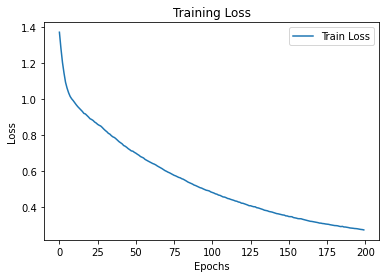

In [80]:
plot_items(np.array(epoch_count), np.array(loss_store),"Epochs","Loss","Train Loss","Training Loss")

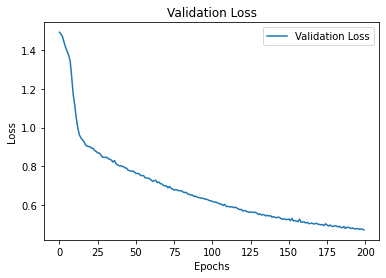

In [81]:
plot_items(np.array(epoch_count), np.array(val_loss_store),"Epochs","Loss","Validation Loss","Validation Loss")

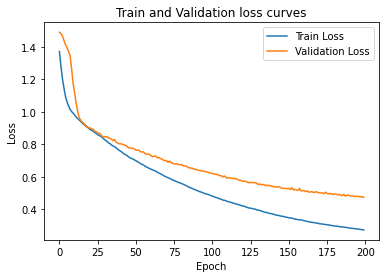

In [82]:
plt.plot(epoch_count, np.array(loss_store), label="Train Loss")
plt.plot(epoch_count, np.array(val_loss_store), label = "Validation Loss")
plt.title("Train and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

In [83]:
np.array(acc_store).shape

(20,)

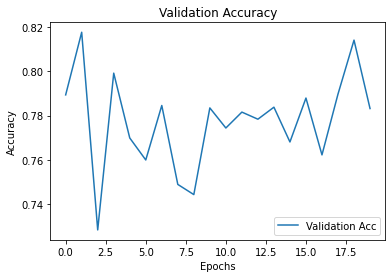

In [84]:
plot_items(np.array(test_epoch_count), np.array(acc_store),"Epochs","Accuracy","Validation Acc","Validation Accuracy")

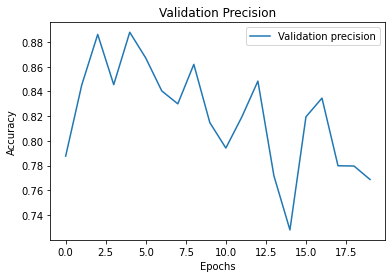

In [85]:
plot_items(np.array(test_epoch_count), np.array(precision_store),"Epochs","Accuracy","Validation precision","Validation Precision")

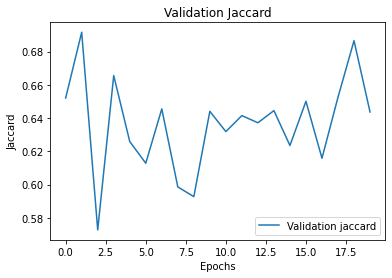

In [86]:
plot_items(np.array(test_epoch_count), np.array(jaccard_store),"Epochs","Jaccard","Validation jaccard","Validation Jaccard")

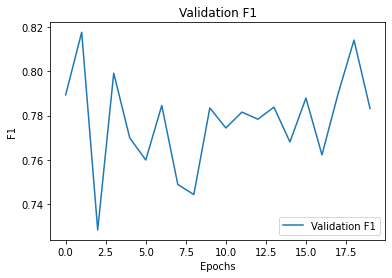

In [87]:
plot_items(np.array(test_epoch_count), np.array(f1_store),"Epochs","F1","Validation F1","Validation F1")

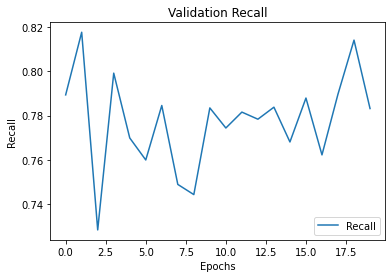

In [88]:
plot_items(np.array(test_epoch_count), np.array(recall_store),"Epochs","Recall","Recall","Validation Recall")

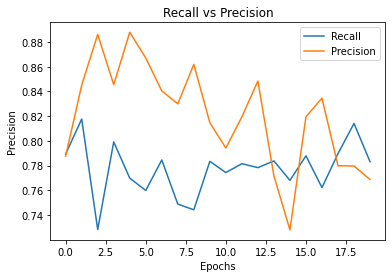

In [89]:
plot_items(np.array(test_epoch_count), np.array(recall_store),"Epochs","Recall","Recall","Recall vs Precision")
plot_items(np.array(test_epoch_count), np.array(precision_store),"Epochs","Precision","Precision","Recall vs Precision")

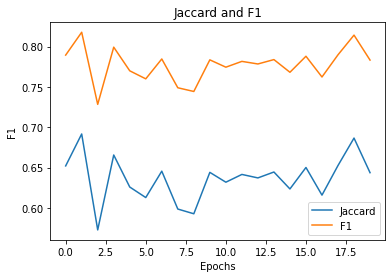

In [90]:
plot_items(np.array(test_epoch_count), np.array(jaccard_store),"Epochs","Jaccard","Jaccard","Jaccard and F1")
plot_items(np.array(test_epoch_count), np.array(f1_store),"Epochs","F1","F1","Jaccard and F1")

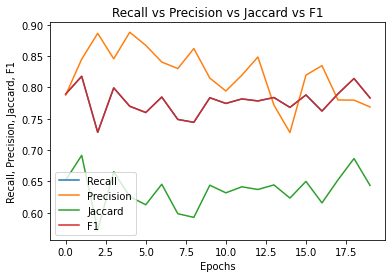

In [91]:
plot_items(np.array(test_epoch_count), np.array(recall_store),"Epochs","Recall, Precision, Jaccard, F1","Recall","Recall vs Precision vs Jaccard vs F1")
plot_items(np.array(test_epoch_count), np.array(precision_store),"Epochs","Recall, Precision, Jaccard, F1","Precision","Recall vs Precision vs Jaccard vs F1")
plot_items(np.array(test_epoch_count), np.array(jaccard_store),"Epochs","Recall, Precision, Jaccard, F1","Jaccard","Recall vs Precision vs Jaccard vs F1")
plot_items(np.array(test_epoch_count), np.array(f1_store),"Epochs","Recall, Precision, Jaccard, F1","F1","Recall vs Precision vs Jaccard vs F1")

In [92]:
import pandas as pd
d1 = pd.Series(recall_store)
d2 = pd.Series(precision_store)
d3 = pd.Series(jaccard_store)
d4 = pd.Series(f1_store)
df = pd.DataFrame(d1, columns=['Recall'])
df['Precision'] = d2
df['Jaccard'] = d3
df['F1'] = d4
df.head()

,Recall,Precision,Jaccard,F1
0,0.789381,0.787729,0.652048,0.789381
1,0.817703,0.845063,0.691622,0.817703
2,0.728323,0.886152,0.572726,0.728323
3,0.799207,0.845526,0.665566,0.799207
4,0.769906,0.887918,0.625892,0.769906


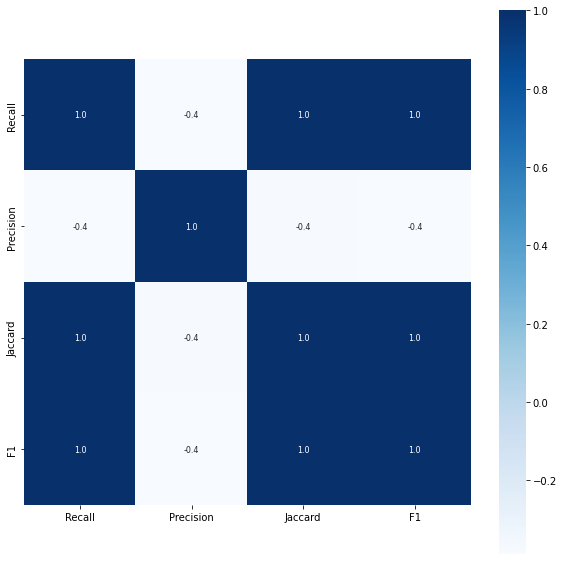

In [93]:
import seaborn as sns
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation,cbar=True,square=True,fmt='.1f', annot=True,annot_kws={'size':8}, cmap='Blues')

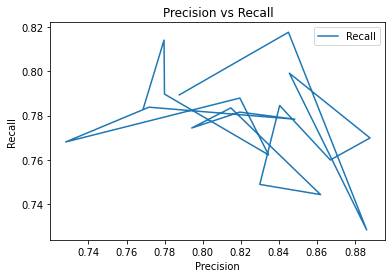

In [94]:
plot_items(np.array(precision_store), np.array(recall_store),"Precision","Recall","Recall","Precision vs Recall")

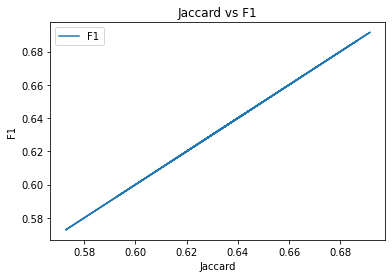

In [95]:
plot_items(np.array(jaccard_store), np.array(jaccard_store),"Jaccard","F1","F1","Jaccard vs F1")